In [36]:
import random

In [37]:
from typing import List, Tuple


def read_line_of_ints(line: str) -> List[int]:
    return [int(x) for x in line.split()]

def read_data(file_path: str) -> Tuple[List[List[int]], List[int]]:
    """
    Read data from file in the following format:
    num_users, num_resources
    num_users x num_resources cost matrix of assigning user i to resource j
    num_resources cost array of building resource j
    """
    with open(file_path, 'r') as f:
        user_resource_cost = []
        for i, line in enumerate(f):
            if i == 0:
                num_users, num_resources = read_line_of_ints(line)
            elif i <= num_users:
                user_resource_cost.append(read_line_of_ints(line))
            else:
                resource_cost = read_line_of_ints(line)
        
        return user_resource_cost, resource_cost


In [38]:
user_resource_cost, resource_cost = read_data('../uflp1.txt')

In [39]:
# mozemo da napravimo alijas za tip, ali, naravno, ne moramo
Solution = List[bool]

Fitnes generalno predstavlja prilagođenost, tako da bi bilo prirodno da želimo što veći fitnes.
Verovatno bi bilo ispravnije da ovo zovemo vrednost funkcije cilja...

In [40]:
def calc_fitness(solution: Solution, user_resource_cost: List[List[int]], resource_cost: List[int]) -> int:
    """Calculate fitness of the given solution"""

    # TODO optimizacija - nekakvo stablo da bi slozenost bila logM

    # ne raditi ovo uvek, ako ima vise nedopustivih resenja moze da se zaglavi lako
    # jer bi tada sva nedopustiva resenja imala isti fitnes (inf)
    if not any(solution):
        return float('inf')
    built_resources_cost = sum(c for i, c in enumerate(resource_cost) if solution[i])
    user_cost = sum(min(x for i, x in enumerate(c) if solution[i]) for c in user_resource_cost)
    return built_resources_cost + user_cost

In [81]:
def local_search_invert_first_improvement(solution: List[bool], fitness: int, user_resource_cost, resource_cost):
    """
    Finds a local minimum starting from the given solution using `invert` operator (flipping bit by bit).
    At each step chooses the FIRST possible improvement from the neighborhood.

    Returns new fitness; solution is changed in place.
    """
    improved = True
    while improved:
        improved = False
        indices = list(range(len(solution)))
        # ako ne bismo shuffle-ovali, postojala bi pristranost prema nizim indeksima
        random.shuffle(indices)
        for i in indices:
            solution[i] = not solution[i]
            # recalc_fitness treba da bude posebna funkcija u kojoj ne pravimo od nule stablo
            # vec parcijalno racnamo fitnes na osnovu trenutne vrednosti i male promene koju smo napravili
            new_fitness = calc_fitness(solution, user_resource_cost, resource_cost)
            if new_fitness < fitness:
                improved = True
                fitness = new_fitness
                break
            else:
                solution[i] = not solution[i]
    return fitness

In [86]:
def local_search_invert_best_improvement(solution: List[bool], fitness: int, user_resource_cost, resource_cost):
    """
    Finds a local minimum starting from the given solution using `invert` operator (flipping bit by bit).
    At each step chooses the BEST possible improvement from the neighborhood.

    Returns new fitness; solution is changed in place.
    """
    improved = True
    while improved:
        improved = False
        best_fitness = fitness
        best_idx = -1
        for i in range(len(solution)):
            # invert temporarily
            solution[i] = not solution[i]
            
            # recalc_fitness treba da bude posebna funkcija u kojoj ne pravimo od nule stablo
            # vec parcijalno racnamo fitnes na osnovu trenutne vrednosti i male promene koju smo napravili
            new_fitness = calc_fitness(solution, user_resource_cost, resource_cost)
            if new_fitness < best_fitness:
                best_fitness = new_fitness
                best_idx = i
            
            # revert to previous solution
            solution[i] = not solution[i]

        if best_idx != -1:
            # actually invert
            solution[best_idx] = not solution[best_idx]
            improved = True

    return fitness

In [ ]:
local_search_invert_best_improvement([False, True, True], )

In [84]:
def local_search_swap_first_improvement():
    pass

In [85]:
def local_search_swap_best_improvement():
    pass

In [87]:
solution = [False, True, True]
fitness = calc_fitness(solution, user_resource_cost, resource_cost)
local_search_invert_first_improvement(solution, fitness, user_resource_cost, resource_cost)

41

In [89]:
solution = [False, True, True]
fitness = calc_fitness(solution, user_resource_cost, resource_cost)
local_search_invert_best_improvement(solution, fitness, user_resource_cost, resource_cost)

41

In [90]:
import itertools

In [92]:
for x in itertools.product([True, False], repeat=3):
    print(x)
    # probati LS za svaki moguci ulaz jer mozemo na ovako malom primeru

(True, True, True)
(True, True, False)
(True, False, True)
(True, False, False)
(False, True, True)
(False, True, False)
(False, False, True)
(False, False, False)


# Simulirano kaljenje

In [45]:
def initialize(num_resources: int):
    """Construct random initial solution"""
    # NOTE: za razlicite probleme koristimo razlicito kodiranje resenja (ne moze uvek niz bitova)
    # i razlicitu verovatnocu
    
    # return [random.random() < 0.5 for i in range(num_resources)]
    return random.choices([True, False], k=num_resources)

In [63]:
from copy import deepcopy


def simulated_annealing(num_iters: int, user_resource_cost: List[List[int]], resource_cost: List[int]):
    """
    Simulated annealing for Uncapacitated Facility Location Problem.
    Stop condition is the given number of iterations.
    """
    solution = initialize(len(resource_cost))
    fitness = calc_fitness(solution, user_resource_cost, resource_cost)
    best_solution = deepcopy(solution)
    best_fitness = fitness
    for it in range(2, num_iters + 2):
        for i in range(len(solution)):
            solution[i] = not solution[i]
            # recalc_fitness treba da bude posebna funkcija u kojoj ne pravimo od nule stablo
            # vec parcijalno racnamo fitnes na osnovu trenutne vrednosti i male promene koju smo napravili
            new_fitness = calc_fitness(solution, user_resource_cost, resource_cost)
            if new_fitness < fitness:
                fitness = new_fitness
                if new_fitness < best_fitness:
                    best_fitness = new_fitness
                    # TODO probati optimizaciju da ne kopiramo uvek
                    best_solution = deepcopy(solution)
                break
            else:
                p = random.random()
                q = 1 / it
                if p < q:
                    fitness = new_fitness
                else:
                    solution[i] = not solution[i]
    return best_solution, best_fitness

In [80]:
simulated_annealing(10, user_resource_cost, resource_cost)

([True, False, False], 34)

### Vizuelizacija nekih od opadajućih funkcija koje možemo da koristimo u simuliranom kaljenju

In [31]:
from matplotlib import pyplot as plt

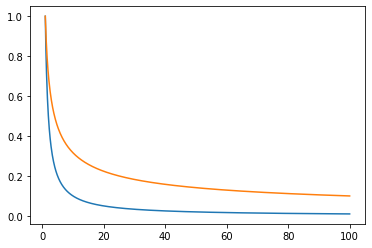

In [33]:
import numpy as np
xs = np.linspace(1, 100, 1000)
plt.plot(xs, 1 / xs)
plt.plot(xs, 1 / np.sqrt(xs))

# Metoda promenljivih okolina (Variable Neighborhood Search)